In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

9.483676147460931


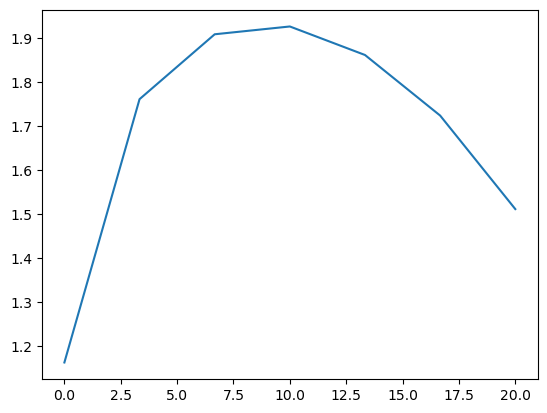

In [2]:
#solve nash bargaining with one insurer

def calc_shares1(p1, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    u1 = (wtp - p1)/cost
    s1 = np.exp(u1)/(np.exp(u1) + 1 )
    return s1
  

def calc_profits_price_shares1(phi1,cost,wtp,mc1):
    pi1 = lambda p : -1*calc_shares1(p, cost, wtp)[0]*(p-phi1 -mc1)
    p1 = minimize(pi1,1,method='Nelder-Mead',tol=1e-6).x
    s1 = calc_shares1(p1,  cost, wtp)
    return p1[0], s1[0], s1[0]*(p1[0]-phi1 -mc1)

def nash_in_nash_obj1(phi1, cost, wtp, mc1, beta=.5):
    p1,s1,profits1 = calc_profits_price_shares1(phi1, cost, wtp, mc1)
    hosp_profit = s1*phi1
    obj = -1*(np.log(hosp_profit)*(1-beta) + np.log(profits1)*beta)

    #print(obj)
    return obj

def nash_in_nash1(cost,wtp,mc1,outside_option=False):
    obj1 = lambda phi : nash_in_nash_obj1(phi,cost,wtp,mc1)
    result = minimize(obj1,13,method='Nelder-Mead',tol=1e-6)
    
    if outside_option:
        return result.x[0]*calc_shares1(result.x[0], cost, wtp)
    return result.x[0]

print(nash_in_nash1(5,25,0))

COST = 5
WTP1 = 25
MC1 = 0

plt.plot([i for i in np.linspace(0,4*COST,num=7)], 
         [-1*nash_in_nash_obj1(i, COST,WTP1,MC1) for i in np.linspace(1,4*COST,num=7)])

In [3]:
#solve nash bargaining with 2 insurers

def calc_shares(p1, p2,  cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    u1 = (wtp[0] - p1)/cost
    u2 = (wtp[1] - p2)/cost
    s1 = np.exp(u1)/(np.exp(u1)+ np.exp(u2) + 1 )
    s2 = np.exp(u2)/(np.exp(u1)+ np.exp(u2) + 1 )
    
    return s1,s2
  

def calc_profits_price_shares(phi1,phi2,cost,wtp,mc):
    mc1,mc2 = mc
    
    p1,p2 = 1,2
    diff =  np.maximum(p1,p1)
    p10,p20 = 0,0
    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        
        pi1 = lambda p : -1*calc_shares(p, p20,  cost, wtp)[0]*(p-phi1 -mc1)
        pi2 = lambda p :  -1*calc_shares(p10, p,  cost, wtp)[1]*(p-phi2 -mc2)

        
        p1 = minimize(pi1,p10).x
        p2 = minimize(pi2,p20).x
        
        #update loop variables
        diff = np.abs(np.maximum(p1 - p10,p2-p20))[0]
        p10,p20 = p1,p2
        maxiter = maxiter-1
        
    s1,s2 = calc_shares(p1, p2,  cost, wtp)
    return p1, p2, s1,s2, s1*(p1-phi1 -mc1), s2*(p2-phi2 -mc2)



#arbitrary outside option...
def nash_in_nash(phi1, phi2, cost, wtp, mc, beta=.5, outside_option=None):
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,cost,wtp,mc)
    hosp_profit = s1*phi1 + s2*phi2
    
    #the passive beliefs case
    if outside_option is None:
        outside_option = s2*phi2
        
    obj = -1*(np.log(max(hosp_profit-outside_option,1e-6))*(1-beta) 
              + np.log(profits1)*beta)
    return obj


COST = 5
WTP = np.array([25,25])
MC = np.array([0,0])

print(nash_in_nash(3*COST,3*COST, COST, WTP, MC))

[-1.41148121]


9.076136151857053


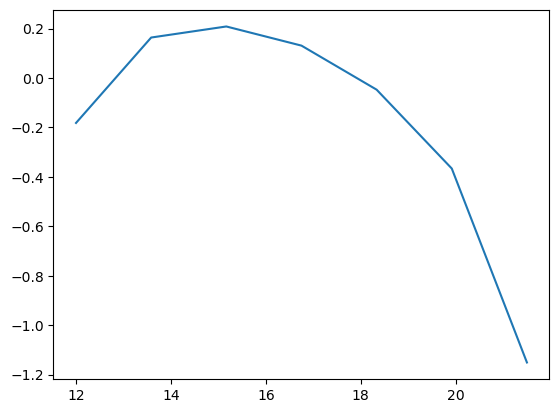

In [4]:
COST = 5
WTP = np.array([25,25])
MC = np.array([0,0])
OUTSIDE = nash_in_nash1(COST,WTP[0],MC[0],outside_option=True)
print(OUTSIDE)

plt.plot([i for i in np.linspace(12,14+1.5*COST,num=7)], 
         [-1*nash_in_nash(i, 10, COST,WTP,MC,outside_option=OUTSIDE) for i in np.linspace(12,14+1.5*COST,num=7)])

In [5]:
def bargain_helper(phi1, phi2, cost, wtp, mc, beta=.5,outside_option=None):
    """solve each firm 1s optimization holding phi 2 fixed"""
    result = minimize(nash_in_nash, phi1, args=(phi2,cost, wtp, mc,  beta, outside_option),
                      method='Nelder-Mead', options={'disp': False})
    return result.x

COST = 5
WTP = np.array([25,25])
MC = np.array([0,0])
OUTSIDE = nash_in_nash1(COST,WTP[0],MC[0],outside_option=True)
print(OUTSIDE)
print(bargain_helper(15,14, COST,WTP,MC,beta=.5,outside_option=OUTSIDE))

9.076136151857053
[13.92626953]


In [6]:
def simult_bargain(phi1, phi2, cost, wtp, mc, betas=[.5,.5],active=False):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables, check on this...
    diff =  np.maximum(phi1,phi2)
    phi10,phi20 = 0,0
    maxiter = 10
    
    outside_option1 = None
    outside_option2 = None
    if active:
        outside_option1 = nash_in_nash1(cost,wtp[0],mc[0],outside_option=True)
        outside_option2 = nash_in_nash1(cost,wtp[1],mc[1],outside_option=True)
        
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        phi1 = bargain_helper(phi1, phi2, cost, wtp, mc, beta=betas[0] ,outside_option=outside_option1)
        phi2 = bargain_helper(phi2, phi1, cost, wtp[::-1], mc[::-1], beta=betas[1],outside_option=outside_option2)
        
        #update loop variables
        diff = np.abs(np.maximum(phi1 - phi10,phi2-phi20))[0]
        phi10,phi20 = phi1,phi2
        maxiter = maxiter-1
        
    return phi1, phi2

COST = 5
WTP = np.array([25,26])
MC = np.array([0,0])
print(simult_bargain(15,15,COST,WTP,MC,active=False))
#print(simult_bargain(15,15,COST,np.array([26,25]),MC,active=True))

(array([7.47324011]), array([7.74787067]))


1 insurer

In [7]:
COST = 5
WTP = 25

print("l" , "phi1", "p1", "hosp", "profit1")
for i in np.linspace(0,3,4):
    mc_i = 0
    phi1 = nash_in_nash1(COST+i,WTP,mc_i)
    p1,s1,profits1 = calc_profits_price_shares1(phi1,COST+i,WTP,mc_i)
    hosp_profit = s1*phi1
    print(COST+i, round(phi1,3), round(p1,3), round(hosp_profit,3), round(profits1,3) )

l phi1 p1 hosp profit1
5.0 9.484 22.586 5.865 8.103
6.0 9.621 23.424 5.439 7.803
7.0 9.854 24.439 5.124 7.585
8.0 10.16 25.591 4.892 7.431


In [9]:
COST = 5
WTP = 25

print("wtp" , "phi1",  "profit1", "hosp",  "p1")
for i in np.linspace(0,3,4):
    mc_i = 0
    phi1 = nash_in_nash1(COST,WTP+i,mc_i)
    p1,s1,profits1 = calc_profits_price_shares1(phi1,COST,WTP+i,mc_i)
    hosp_profit = s1*phi1
    print(WTP+i, round(phi1,3),  round(profits1,3), round(hosp_profit,3), round(p1,3), )

wtp phi1 profit1 hosp p1
25.0 9.484 8.103 5.865 22.586
26.0 9.851 8.498 6.202 23.348
27.0 10.221 8.897 6.544 24.118
28.0 10.596 9.301 6.891 24.897


passive beliefs`

In [8]:
COST = 5
WTP = np.array([25,25])

print("v" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,5,6):
    mc_i = np.array([0, 0])
    phi1,phi2 = simult_bargain(7,7,COST,WTP+i,mc_i,active=False)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST,WTP+i,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(WTP[0]+i,WTP[0]+i, round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v phi 1 phi 2 hosp profit profit 1 profit 2
25.0 25.0 7.506 7.499 16.704 16.701 6.851 4.198 4.203
26.0 26.0 7.717 7.713 17.006 17.004 7.126 4.289 4.291
27.0 27.0 7.923 7.918 17.294 17.292 7.39 4.371 4.374
28.0 28.0 8.123 8.122 17.57 17.57 7.648 4.447 4.448
29.0 29.0 8.31 8.308 17.825 17.824 7.887 4.516 4.517
30.0 30.0 8.493 8.495 18.071 18.072 8.12 4.579 4.578


In [10]:
COST = 5
WTP = np.array([25,25])

print("v" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,5,6):
    mc_i = np.array([0, 0])
    phi1,phi2 = simult_bargain(7,7,COST+i,WTP,mc_i,active=False)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST+i,WTP,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(COST+i, round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v phi 1 phi 2 hosp profit profit 1 profit 2
5.0 7.506 7.499 16.704 16.701 6.851 4.198 4.203
6.0 7.897 7.893 18.398 18.396 6.769 4.501 4.503
7.0 8.292 8.29 19.992 19.991 6.662 4.701 4.702
8.0 8.713 8.713 21.56 21.56 6.575 4.847 4.847
9.0 9.16 9.159 23.126 23.125 6.514 4.967 4.967
10.0 9.631 9.632 24.705 24.705 6.484 5.074 5.074


active beliefs

In [16]:
COST = 5
WTP = np.array([25,25])

print("v" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,3,4):
    mc_i = np.array([0, 0])
    phi1,phi2 = simult_bargain(22,22,COST+i,WTP,mc_i,active=True)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST+i,WTP,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(COST+i, round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v phi 1 phi 2 hosp profit profit 1 profit 2
5.0 13.93 13.931 22.128 22.129 10.87 3.199 3.198
6.0 14.768 14.773 24.014 24.017 10.37 3.247 3.244
7.0 15.768 15.771 26.015 26.017 9.993 3.247 3.246
8.0 16.882 16.88 28.113 28.111 9.714 3.231 3.232


In [11]:
COST = 5
WTP = np.array([25,25])

print("v" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,5,6):
    mc_i = np.array([0, 0])
    phi1,phi2 = simult_bargain(22,22,COST,WTP+i,mc_i,active=True)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST,WTP+i,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(WTP[0]+i,WTP[0]+i, round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v phi 1 phi 2 hosp profit profit 1 profit 2
25.0 25.0 13.93 13.931 22.128 22.129 10.87 3.199 3.198
26.0 26.0 14.345 14.345 22.652 22.652 11.422 3.307 3.307
27.0 27.0 14.769 14.768 23.18 23.179 11.979 3.411 3.411
28.0 28.0 15.201 15.201 23.711 23.712 12.541 3.511 3.511
29.0 29.0 15.643 15.64 24.248 24.247 13.108 3.605 3.607
30.0 30.0 16.089 16.09 24.786 24.787 13.679 3.697 3.697


In [12]:
COST = 5
WTP = np.array([25,25])

print("v1" ,"v2" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,5,6):
    mc_i = np.array([0, 0])
    wtp_i = np.array([WTP[0]+i,WTP[1]])
    phi1,phi2 = simult_bargain(22,22,COST,wtp_i,mc_i,active=True)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST,wtp_i,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(wtp_i[0],wtp_i[1], round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v1 v2 phi 1 phi 2 hosp profit profit 1 profit 2
25.0 25.0 13.93 13.931 22.128 22.129 10.87 3.199 3.198
26.0 25.0 14.668 13.61 22.906 21.878 11.145 3.238 3.268
27.0 25.0 15.409 13.3 23.686 21.634 11.421 3.277 3.334
28.0 25.0 16.143 12.992 24.461 21.39 11.696 3.318 3.398
29.0 25.0 16.886 12.696 25.242 21.154 11.974 3.357 3.458
30.0 25.0 17.632 12.405 26.027 20.922 12.253 3.395 3.517


In [13]:
COST = 5
WTP = np.array([25,25])

print("v1" ,"v2" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,5,6):
    mc_i = np.array([0, 0])
    wtp_i = np.array([WTP[0],WTP[1]+i])
    phi1,phi2 = simult_bargain(22,22,COST,wtp_i,mc_i,active=True)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST,wtp_i,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(wtp_i[0],wtp_i[1], round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v1 v2 phi 1 phi 2 hosp profit profit 1 profit 2
25.0 25.0 13.93 13.931 22.128 22.129 10.87 3.199 3.198
25.0 26.0 13.61 14.669 21.878 22.906 11.145 3.268 3.238
25.0 27.0 13.298 15.405 21.632 23.683 11.42 3.334 3.278
25.0 28.0 12.995 16.148 21.393 24.465 11.697 3.397 3.316
25.0 29.0 12.696 16.888 21.154 25.244 11.974 3.459 3.356
25.0 30.0 12.406 17.634 20.923 26.028 12.253 3.517 3.394
